In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from fastai.data.core import DataLoaders
from fastai.data.transforms import TrainTestSplitter
from fastai.optimizer import OptimWrapper
from fastai.learner import Learner
from fastai.callback.progress import ProgressCallback
from fastai.callback.data import CudaCallback

from PIL import Image
import numpy as np
import random

# seed function for reproducibility
def random_seed(seed_value):
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value) 
    random.seed(seed_value) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
        
random_seed(113) 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Load the Dataset

In [20]:
train_dir = "train/"
test_dir = "test/"

In [21]:
img_size = 150

train_transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.RandomRotation(5), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


test_transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_img = datasets.ImageFolder(train_dir, transform=train_transform)
test_img = datasets.ImageFolder(test_dir, transform=test_transform)

# Explore the Data

In [22]:
print("train_img type   :",type(train_img))
print("train_img length :",len(train_img))
print("test_img length :",len(test_img))
print("train_img classes:",train_img.classes)
print("train_img[0] type:",type(train_img[0]))
print("train_img[0][0] t:",type(train_img[0][0]))
print("train_img[0][1] t:",type(train_img[0][1]))
print("train_img[0][0] s:",train_img[0][0].size())
print("train_img[0][1]  :",train_img[0][1])

n_labels = len(train_img.classes)

train_img type   : <class 'torchvision.datasets.folder.ImageFolder'>
train_img length : 940
test_img length : 120
train_img classes: ['JUICE', 'MILK', 'SODA', 'VINEGAR', 'WATER']
train_img[0] type: <class 'tuple'>
train_img[0][0] t: <class 'torch.Tensor'>
train_img[0][1] t: <class 'int'>
train_img[0][0] s: torch.Size([3, 150, 150])
train_img[0][1]  : 0


In [23]:
def imshow(data_image, tensor=False):
    image = data_image[0]
    label = data_image[1]
    image = image.numpy().transpose((1, 2, 0))

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5],)
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.show()
    
    print(train_img.classes[label])

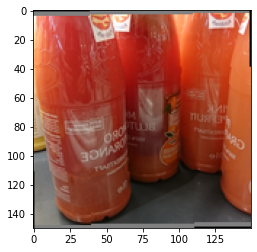

JUICE


In [24]:
imshow(train_img[0])

# Create the Loader

In [25]:
trainloaders = torch.utils.data.DataLoader(train_img, batch_size=64, shuffle=True, num_workers=0)
testloaders = torch.utils.data.DataLoader(test_img, batch_size=32, shuffle=True, num_workers=0)
dls = DataLoaders(trainloaders, testloaders)

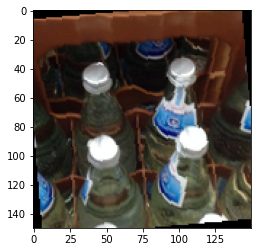

WATER


In [26]:
for image, label in trainloaders:
    for i in range(1):
        imshow((image[i], label[i]))
    break

# Create the Architecture

**Attention**. There are some styles to create a model:

1. using `class`
2. using `sequential`
3. both styles combined

I suggest to use `sequential` only for a simple model, or for a simple part of the class. In the example below, you can see three different ways to create a model.

please also remember the formula to calculate the size of feature after convolution (defined in `self.conv_size()`):

$$\frac{(FEATURE - KERNEL + 2*PADDING)}{STRIDE} +1$$

In [27]:
########################
# 1. Neural Net Model using Class (the most common)
#######################

class Net(nn.Module):
    
    def __init__(self, ks=4, ps=3, fm1=16, fm2=32, n=256):
    
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, fm1, kernel_size=ks, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=ps, stride=2, padding=0)
        self.conv2 = nn.Conv2d(fm1, fm2, kernel_size=ks, stride=1, padding=0)
        
        # calculate CNN's output size
        res = self.conv_size(self.conv_size(self.conv_size(self.conv_size(img_size, ks), ps, s=2), ks), ps, s=2)**2*fm2
        
        self.fc1 = nn.Linear(res, n)
        self.fc2 = nn.Linear(n, n_labels)
        self.do = nn.Dropout()

    def conv_size(self, inp, k, p=0, s=1):
        return (inp-k+2*p)//s+1
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.do(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
model = Net()

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def opt_func(params, **kwargs):
    return OptimWrapper(optimizer)

epoch = 10

In [29]:
learn = Learner(dls, model, loss_func=criterion, cbs=[CudaCallback])

In [30]:
learn.fit(epoch)

epoch,train_loss,valid_loss,time
0,1.707863,1.388419,00:08
1,1.470137,1.146755,00:09
2,1.331019,1.076511,00:09
3,1.230501,1.060935,00:09
4,1.151980,0.958443,00:09
5,1.085215,0.955149,00:09
6,1.026349,0.924299,00:09
7,0.956507,0.860203,00:10
8,0.911120,0.849159,00:09
9,0.861529,0.801704,00:11


In [34]:
torch.save(learn.model, './model.pth')

# Sanity Check

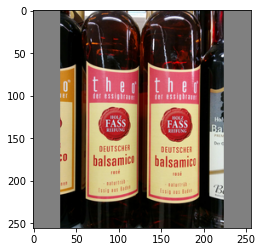

In [33]:
imagepath = "VINEGAR0139.png"
image_test = Image.open(imagepath)
plt.imshow(image_test)
plt.show()

In [35]:
model = torch.load("model.pth").eval()
image_transformed = test_transform(image_test) 
image_transformed = image_transformed.unsqueeze(0).to(device)
out = model(image_transformed)
print(out)
print("PREDICTION:", train_img.classes[torch.max(out,1)[1]])

tensor([[ 0.9334, -5.1605,  2.1434,  5.6783, -5.0297]], device='cuda:0',
       grad_fn=<AddmmBackward>)
PREDICTION: VINEGAR
